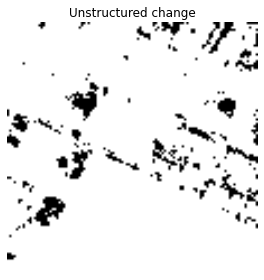

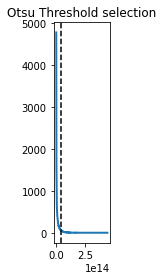

In [ ]:

import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import sys
from skimage import filters
from skimage import exposure
from keras import backend as K

#Function to retrieve features from intermediate layers
def get_activations(model, layer_idx, X_batch):
    get_activations = K.function(model.layers[0].input, [model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

def extra_feat(img_path):
        #Using a VGG19 as feature extractor
        base_model = VGG19(weights='imagenet',include_top=False)
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        block1_pool_features=get_activations(base_model, 1, x)
        block2_pool_features=get_activations(base_model, 3, x)
        block3_pool_features=get_activations(base_model, 5, x)
        block4_pool_features=get_activations(base_model, 17, x)
        block5_pool_features=get_activations(base_model, 19, x)

        x1 = tf.image.resize(block1_pool_features[0],[112,112])
        x2 = tf.image.resize(block2_pool_features[0],[112,112])
        x3 = tf.image.resize(block3_pool_features[0],[112,112])
        x4 = tf.image.resize(block4_pool_features[0],[112,112])
        x5 = tf.image.resize(block5_pool_features[0],[112,112])
                
        F = tf.concat([x3,x2,x1,x4,x5],3) 
        return F

def main():
  if (len(sys.argv))>3:
    print("Invalid number of input arguments ")
    exit(0)

  #Two aerial patches with change or No change
  img_path1="old3.png"
  img_path2="new3.png"

  F1=extra_feat(img_path1) #Features from image patch 1
  F1=tf.square(F1)
  F2=extra_feat(img_path2) #Features from image patch 2
  F2=tf.square(F2)
  d=tf.subtract(F1,F2)
  d=tf.square(d) 
  d=tf.reduce_sum(d,axis=3) 

  dis=(d.numpy())   #The change map formed showing change at each pixels
  dis=np.resize(dis,[112,112])

  # Calculating threshold using Otsu's Segmentation method
  val = filters.threshold_otsu(dis[:,:])
  hist, bins_center = exposure.histogram(dis[:,:],nbins=256)

  plt.title('Unstructured change')
  plt.imshow(dis[:,:] < val, cmap='gray', interpolation='bilinear')
  plt.axis('off')
  plt.tight_layout()
  plt.show()
  
  #Uncomment For veiwing a graph for visualizing threshold selection
  plt.subplot(144)
  plt.title('Otsu Threshold selection')
  plt.plot(bins_center, hist, lw=2)
  plt.axvline(val, color='k', ls='--')

  plt.tight_layout()
  plt.show()
  
if __name__ == "__main__":
    main()


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread('old1.png',0)
kernel = np.ones((5,5), np.uint8)

img_dilate = cv2.dilate(img, kernel, iterations=1)

cv2_imshow(img_dilate)


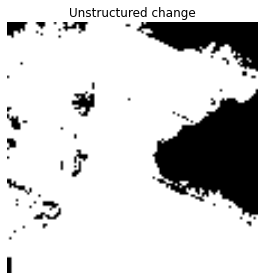

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
import tensorflow as tf
import keras
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import sys
from skimage import filters #change to 'import filter' for Python>v2.7
from skimage import exposure
from keras import backend as K

#Function to retrieve features from intermediate layers
def get_activations(model, layer_idx, X_batch):
    get_activations = K.function(model.layers[0].input, [model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

#Function to extract features from intermediate layers
def extra_feat(img_path):
        #Using a VGG19 as feature extractor
        base_model = InceptionResNetV2(weights='imagenet',include_top=False)
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        block1_pool_features=get_activations(base_model, 1, x)
        block2_pool_features=get_activations(base_model, 3, x)
        block3_pool_features=get_activations(base_model, 5, x)
        block4_pool_features=get_activations(base_model, 27, x)
        block5_pool_features=get_activations(base_model, 39, x)
       # block6_pool_features=get_activations(base_model, 55, x)

        x1 = tf.image.resize(block1_pool_features[0],[112,112])
        x2 = tf.image.resize(block2_pool_features[0],[112,112])
        x3 = tf.image.resize(block3_pool_features[0],[112,112])
        x4 = tf.image.resize(block4_pool_features[0],[112,112])
        x5 = tf.image.resize(block5_pool_features[0],[112,112])
       # x6 = tf.image.resize(block6_pool_features[0],[112,112])
                
        F = tf.concat([x1,x2,x3,x4,x5],3) #Change to only x1, x1+x2,x1+x2+x3..so on, inorder to visualize features from different blocks
        return F

def main():
  if (len(sys.argv))>3:
    print("Invalid number of input arguments ")
    exit(0)

  #Two aerial patches with change or No change
  img_path1="old3.png"
  img_path2="new3.png"

  F1=extra_feat(img_path1) #Features from image patch 1
  F1=tf.square(F1)
  F2=extra_feat(img_path2) #Features from image patch 2
  F2=tf.square(F2)
  d=tf.subtract(F1,F2)
  d=tf.square(d) 
  d=tf.reduce_sum(d,axis=3) 

  dis=(d.numpy())   #The change map formed showing change at each pixels
  dis=np.resize(dis,[112,112])

  # Calculating threshold using Otsu's Segmentation method
  val = filters.threshold_otsu(dis[:,:])
  hist, bins_center = exposure.histogram(dis[:,:],nbins=256)

  plt.title('Unstructured change')
  plt.imshow(dis[:,:] < val, cmap='gray', interpolation='bilinear')
  plt.axis('off')
  plt.tight_layout()
  plt.show()
  
  
if __name__ == "__main__":
    main()
